# Notebook for creating a labelbox project with bounding box annotations as pre-labels
* This notebook needs the output csv created from model inference. The output csv already has the bounding box information for each class. This notebook loads it, unrectifies the bounding box co-ordinates from rectified image space to the unrectified image space, creates bounding box annotations in aletheia and then creates a labelbox project with these annotations.
* You can also optionally filter the images that you want to send for labelling. You can prune out similar images by reading the csv from image similarity, perform metadata based deduplication and filter out images based on pixel counts as the images with large pixel counts are likely going to be TPs.
* There is also a debug section at the end where you can visualize the images that you have selected with their corresponding bounding boxes

#### TODO:
* If you face any long Forbidden errors, you likely don't have permissions to create Annotations in aletheia or add data to Labelbox projects. Please ask Mesa to give you access for both of these.
* There are also other TODOs in this notebook like pointing to the right csvs, filtering, label policy, etc. Please update them according to your needs

#### Limitations:
* There is only one bounding box created per class for an image. If there are multiple objects of the same class, the bounding box would encompass all of them.

References:
* For unrectifying bounding boxes: https://github.com/BlueRiverTechnology/JupiterTerraform/blob/main/lambdas/stop_event_labeling/dbx_to_labelbox.py

In [41]:
import os
CVML_DIR = "/home/li.yu/code/testing/JupiterCVML"
EUROPA_DIR = os.path.join(CVML_DIR, "europa/base/src/europa")

import sys
sys.path.insert(0, EUROPA_DIR)
sys.path.insert(0, CVML_DIR)

import ast
import sys
import os
import json
import traceback
os.environ["BRT_ENV"] = 'prod'
os.environ['AWS_PROFILE'] = 'default'
import random
import brtdevkit
print(brtdevkit.__version__)
brtdevkit.log = 'info'
USERNAME = 'li.yu'
import datetime
import numpy as np
import pandas as pd
import glob
import time

from brtdevkit.core import AnnotationJob, Annotation, LabelMap, LabelProject
from brtdevkit.data import Dataset
from jupiterdata.utils.dataset import query_db, query_db_batch, annotation_ids_to_dataset, imageids_to_annotation_df, annotationids_to_dataframe
from image_search.constants import LABELS
from pandarallel import pandarallel

from dl.dataset.pack_perception.load_calibration_data import get_calibration_data

%matplotlib inline
%load_ext autoreload
%autoreload 2

8.7.0
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Setup the label policy, label map and desired labels

In [2]:
# TODO: Update the label policy and label map id if your requirments are different
# Defaults are set to https://aletheia.brtws.com/jupiter/labeling/policies/191 and https://aletheia.brtws.com/jupiter/labeling/maps/295

LABEL_MAP_ID = 295
LABEL_POLICY = 191 # Jupiter label triage of model predictions with segmentation of images with false predictions

LABEL_MAP = {}
for info in LabelMap.retrieve(LABEL_MAP_ID)["classes"]:
    LABEL_MAP[info["class_entity_id"]] = info["class_number"]
print(LABEL_MAP)

{'tilled_field': 1, 'untilled_field': 2, 'road': 3, 'trees': 6, 'sky': 7, 'immovable_objects': 8, 'buildings': 9, 'tractors_or_vehicles': 10, 'humans': 11, 'animals': 12, 'ignore': 13, 'ego_tractor': 19, 'heavy_dust': 22, 'birds': 23, 'tall_weeds': 24, 'airborne_debris': 25, 'cotton_debris': 26, 'object_lights': 27, 'flooded_area': 28, 'ego_reflective_surface': 29, 'ego_mirror_housing': 30, 'unharvested_field': 31, 'grain': 32, 'combine': 33, 'grain_cart': 34, 'semi': 35, 'trench': 36, 'mound': 37, 'heavy_brush': 38, 'non_ego_implement': 39, 'implement': 14, 'utility_pole': 5, 'drivable_debris': 40, 'model_large_object': 128, 'model_human': 129, 'model_other': 130, 'model_trees': 131, 'model_implement': 132, 'model_unharvested_field': 133, 'model_vehicle': 134}


### Defines all the required functions here

In [42]:
def get_artifact_kind(row):
    if not pd.isna(row.get("artifact_debayeredrgb_0_save_path")) or not pd.isna(row.get("artifact_debayeredrgb_0__id")):
        return "debayeredrgb"
    elif not pd.isna(row.get("artifact_rgb_0_save_path")) or not pd.isna(row.get("artifact_rgb_0__id")):
        return "rgb"
    else:
        return None

def unrectify_row(row, dataset_dir):
    """
    Unrectify the row by applying the rectification matrix to the roi points
    :param row: dataframe row
    :return: list of bbox to use for annotation creation
    """
    calibration_data = get_calibration_data(row)
    
    model_output = ast.literal_eval(row['features'])
    
    stereo_npz = np.load(os.path.join(dataset_dir, row["stereo_pipeline_npz_save_path"]), allow_pickle=True)
    rectified_calib = stereo_npz["rectified_calibration_data"][()]

    rectification_matrix = np.array(rectified_calib['R1']).reshape(3,3)
    projection_matrix = np.array(rectified_calib['P1']).reshape(3,4)[:3, :3]
    
    k = rectified_calib["K1"]
    d = np.zeros(8)
    d[:len(rectified_calib['D1'])] = rectified_calib['D1'][:8]
        
    f_x, _, c_x, _, f_y, c_y, _, _, _ = k
    k_1, k_2, p_1, p_2, k_3, k_4, k_5, k_6 = d

    def transform_point_to_unrectified(pixel_point):
        # ref https://docs.opencv.org/4.7.0/d9/d0c/group__calib3d.html
        homogeneous_point = np.array([pixel_point[0], pixel_point[1], 1]) 
        x_rect = np.dot(np.linalg.inv(projection_matrix), homogeneous_point)
        
        x_unrect = np.dot(rectification_matrix.T, x_rect)
        x_prime, y_prime = x_unrect[:2] / x_unrect[2]
        
        r_2 = x_prime ** 2 + y_prime ** 2
        x_distorted = x_prime * (1 + k_1 * r_2 + k_2 * r_2 ** 2 + k_3 * r_2 ** 3)  / \
            (1 + k_4 * r_2 + k_5 * r_2 ** 2 + k_6 * r_2 ** 3) + \
            2 * p_1 * x_prime * y_prime + p_2 * (r_2 + 2 * x_prime ** 2)
        y_distorted = y_prime * (1 + k_1 * r_2 + k_2 * r_2 ** 2 + k_3 * r_2 ** 3)  / \
            (1 + k_4 * r_2 + k_5 * r_2 ** 2 + k_6 * r_2 ** 3) + \
            p_1 * (r_2 + 2 * y_prime ** 2) + 2 * p_2 * x_prime * y_prime
        #
        u = f_x * x_distorted + c_x
        v = f_y * y_distorted + c_y
        return u, v
    output = []
    for label_name in LABELS:
        if label_name in DESIRED_LABELS and model_output[f"{label_name}_pixels_depth_filtered"] > 0:
            left, top, right, bottom = model_output[f"{label_name}_min_col_depth_filtered"], model_output[f"{label_name}_min_row_depth_filtered"], model_output[f"{label_name}_max_col_depth_filtered"], model_output[f"{label_name}_max_row_depth_filtered"]
            if left < 0 or right < 0 or top < 0 or bottom < 0:
                continue
            roi_points = np.array([[left, top], [right, top], [right, bottom], [left, bottom]])
            new_points = np.array([transform_point_to_unrectified(point) for point in roi_points])
            new_left, new_top, new_right, new_bottom = np.min(new_points[:,0]), np.min(new_points[:,1]), np.max(new_points[:,0]), np.max(new_points[:,1])
            output.append(create_bbox_from_model_output(
                label_name,
                [new_left, new_top, new_right, new_bottom],
                model_output["confidence"],
            ))
    return output

def create_bbox_from_model_output(label_name, ltrb, confidence = 1.0):
    # Handle different conventions between model predicted label names and label names in label policy
    if not label_name.startswith('model_'):
        label_name = f"model_{label_name}"
    # Handle unharvested field label name
    if label_name == "model_dense_vegetation":
        label_name = "model_unharvested_field"
    if label_name not in LABEL_MAP:
        label_name = "model_other"
        
    label_id = LABEL_MAP[label_name]
    bbox = {
        "top_left": [
            int(ltrb[0]), 
            int(ltrb[1])
        ],
        "bottom_right": [
            int(ltrb[2]), 
            int(ltrb[3])
        ],
        "data_class": label_id,
        "confidence": confidence,
    }

    return bbox


def create_annotations(result_df, dataset_dir):
    """
    Create annotation ids based on the result dataframe.
    :param result_df: dataframe, the result of the query to get the image_ids and trigger json 
    :return: list of annotation ids
    """
    def create_annotation(df_id, dataset_dir):
        output = None
        bboxes = []
        for _, row in df_id.iterrows():
            try:
                bboxes += unrectify_row(row, dataset_dir)
            except Exception as e:
                print(f"Error in unrectifying image {row['id']}, defaulting to rectified roi")
                print(e)
                traceback.print_exc()
                return output
            
        if len(bboxes) == 0:
            return output
        
        try:
            anno = Annotation(
                image_id=row['id'], 
                values = {
                    "kind":'machine',
                    "style":'bounding_box',
                    "state": "ok",
                    "bounding_boxes": bboxes,
                    "label_map_v2_id": LABEL_MAP_ID,
                    "label_policy_v2_id": LABEL_POLICY,
                }
            )
            anno.create()
            output = {"annotation_id": anno['id'], "id": row["id"]}
        except Exception as e:
            print(f"Error in creating annotation for image {row['id']}")
            print(e)
            traceback.print_exc()
        return output
    # Create one annotation per image id. Combines bounding boxes for left images that are part of two different stereo pairs into one annotation
    annotation_series = result_df.groupby("id").parallel_apply(lambda subset: create_annotation(subset, dataset_dir))
    annotation_ids = [row["annotation_id"] for row in annotation_series if row is not None]
    valid_ids = [row["id"] for row in annotation_series if row is not None]
    return annotation_ids, valid_ids

def send_annotations_to_labelbox(annotation_df, labelbox_project_id):
    """
    Given annotation_df, sends annotations to labelbox according to their artifact kind.
    :param annotation_df: annotation_df with annotation_ids and artifact_kind columns
    :param labelbox_project_id: string, the labelbox project to send the images to 
    """    
    for artifact_kind, temp_df in annotation_df.groupby("artifact_kind"):
        temp_annotation_ids = list(temp_df["annotation_id"])
        payload = {
            'artifact_kind': artifact_kind,
            'labelbox_project_id': labelbox_project_id,
            'annotation_ids': temp_annotation_ids,
        }
        if artifact_kind.startswith('debayeredrgb'):
            print(f"Sending {len(temp_annotation_ids)} debayeredrgb images to LB project: {labelbox_project_id}" )
            res = AnnotationJob.create(AnnotationJob.Vendor.LABELBOX, **payload)
            print(f"Response: {res}")
        elif artifact_kind.startswith('rgb'):
            print(f"Sending {len(temp_annotation_ids)} rgb images to LB project: {labelbox_project_id}" )
            res = AnnotationJob.create(AnnotationJob.Vendor.LABELBOX, **payload)
            print(f"Response: {res}")
        else:
            raise ValueError(f"Unsupported artifact_kind: {artifact_kind} for {len(temp_annotation_ids)} images")

# Load the required information from csvs

In [11]:
# TODO: Point to the dataset directory
dataset_root = "/data3/jupiter/datasets/"
dataset_name = 'model_positive/halo_rain_collection_jf209_stereo'
dataset_dir = os.path.join(dataset_root, dataset_name)

# TODO: Point to the image similarity or model output csvs
# csv_paths = glob.glob(f"/mnt/sandbox1/rakhil.immidisetti/output/driveable_terrain_model/*/{dataset_name}-best-/image_similarity_reduced_1*.csv")
csv_paths = glob.glob(f"/data/jupiter/li.yu/exps/driveable_terrain_model/*/{dataset_name}/output.csv")

print(len(csv_paths))

dfs = []
run_ids = []
for csv_path in sorted(csv_paths):
    run_id = csv_path.split("/")[-3]
    run_ids.append(run_id)
    df_temp = pd.read_csv(csv_path)
    print(f"Len of {csv_path} is {len(df_temp)}")

    if not csv_path.endswith("output.csv"):
        output_dir = os.path.dirname(csv_path)
        output_csv = os.path.join(output_dir, "output.csv")
        df_output = pd.read_csv(output_csv)
        
        df_temp = df_temp.merge(df_output[['unique_id', 'result_state', 'result_human_state', 'result_vehicle_state', 'features']], on='unique_id')

    dfs.append(df_temp)

df = pd.concat(dfs)
print("Concatenated len:", len(df))
df = df.drop_duplicates(subset="unique_id")
print("Final df len:", len(df))

# Merge with master csvs when output csvs are used as output csv doesn't have the calibration data information
if csv_path.endswith("output.csv"):
    df_master = pd.read_csv(os.path.join(dataset_dir, "master_annotations.csv"))
    print(df_master.shape)
    
    df = df_master.merge(df[['unique_id', 'result_state', 'result_human_state', 'result_vehicle_state', 'features']], on='unique_id')
    print(df.shape)

RUN_ID = ", ".join(run_ids)
print(RUN_ID)

3
Len of /data/jupiter/li.yu/exps/driveable_terrain_model/11_3_rev1_train_human_test_dean_multires_ignore_trees_1p25_u_p5_h_p2_v_ft_from_rev1_22kdust_ft_p15dust_h_fresh_dust11/model_positive/halo_rain_collection_jf209_stereo/output.csv is 23687
Len of /data/jupiter/li.yu/exps/driveable_terrain_model/kore_10_lo_10_tr/model_positive/halo_rain_collection_jf209_stereo/output.csv is 23687
Len of /data/jupiter/li.yu/exps/driveable_terrain_model/kore_5_h/model_positive/halo_rain_collection_jf209_stereo/output.csv is 23687
Concatenated len: 71061
Final df len: 23687
(23687, 75)
(23687, 79)
model_positive, model_positive, model_positive


In [6]:
assert "online_calibration_results" in df.columns and "rectification_params" in df.columns

In [12]:
df_bp = df.copy()

## Select images that you want to send for labelling 

In [13]:
pandarallel.initialize(nb_workers=8, progress_bar=False, verbose=2)

# Create annotations only for desired rows i.e model positives. 
df_desired = df[df["result_state"] == "false_positive"]

# TODO: Desired model output labels to send for labelling
# DESIRED_LABELS = ["human", "vehicle", "large_object", "dense_vegetation"]
# DESIRED_LABELS = ["large_object"]
# DESIRED_LABELS = ["human", "dense_vegetation"]
DESIRED_LABELS = ["human", "large_object"]

for label in DESIRED_LABELS:
    df_desired[f"{label}_pixels_depth_filtered"] = df_desired["features"].parallel_apply(lambda x: ast.literal_eval(x)[f"{label}_pixels_depth_filtered"])

print(df_desired.shape)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/tmp/ipykernel_958873/330598746.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_desired[f"{label}_pixels_depth_filtered"] = df_desired["features"].parallel_apply(lambda x: ast.literal_eval(x)[f"{label}_pixels_depth_filtered"])


(3939, 81)


/tmp/ipykernel_958873/330598746.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_desired[f"{label}_pixels_depth_filtered"] = df_desired["features"].parallel_apply(lambda x: ast.literal_eval(x)[f"{label}_pixels_depth_filtered"])


In [46]:
df_filtered = df_desired.copy()

## TODO: Optionally select only human FPs
# df_filtered = df_filtered[df_filtered["result_human_state"] == "false_positive"]

print(len(df_filtered))

## TODO: Optionally filter based on  pixel counts. Large pixel counts are likely TPs
# df_filtered = df_filtered[(df_filtered["dense_vegetation_pixels_depth_filtered"].between(75, 1_000) | df_filtered["human_pixels_depth_filtered"].between(75, 2_000) | df_filtered["large_object_pixels_depth_filtered"].between(75, 1_000)) & df_filtered["vehicle_pixels_depth_filtered"].between(-1, 75)]
# df_filtered = df_filtered[(df_filtered["dense_vegetation_pixels_depth_filtered"].between(75, 1_000) | df_filtered["human_pixels_depth_filtered"].between(75, 5_000) | df_filtered["large_object_pixels_depth_filtered"].between(75, 1_000))]
df_filtered = df_filtered[df_filtered["human_pixels_depth_filtered"].between(75, 5_000) | df_filtered["large_object_pixels_depth_filtered"].between(75, 2_000)]
# df_filtered = df_filtered[df_filtered["human_pixels_depth_filtered"].between(75, 2_000)]
print(len(df_filtered))

3939
1241


In [47]:
# Filter already labelled images
labelled_df = imageids_to_annotation_df(list(df_filtered["id"]))

print("Previous df len:", len(df_filtered))
df_filtered = df_filtered[~df_filtered["id"].isin(labelled_df["id"])]

print("Images already labelled:", len(labelled_df))
print("Updated df len:", len(df_filtered))

INFO:databricks.sql.client:Successfully opened session 01efb424-a136-183c-9a87-27c9ecc8df41
INFO:databricks.sql.client:Closing session 01efb424-a136-183c-9a87-27c9ecc8df41


Filtered 0 annotations with non-production label map.
Warning 1239 images do not have a corresponding annotation.
Previous df len: 1241
Images already labelled: 2
Updated df len: 1238


In [48]:
# Filter images in labelbox queue
test_dataset = Dataset.retrieve(name='20241204_halo_no_grain_cart_diversity_left')
# test_dataset = Dataset.retrieve(name='halo_water_on_ground_samwise_for_labeling')
print(test_dataset.id)
test_df = test_dataset.to_dataframe()
print(test_df.shape)

df_filtered = df_filtered[~df_filtered["id"].isin(test_df["id"])]
print("Updated df len:", len(df_filtered))

6750df14bd9b651208b53ea6
(4078, 138)
Updated df len: 1238


### Metadata deduplication

In [49]:
geohash_length = 7 # 7 corresponds to ~ 150 x 150 m
df_filtered['geohash6'] = df_filtered.geohash.parallel_apply(lambda x: x[:6])
df_filtered['geohash_short'] = df_filtered.geohash.parallel_apply(lambda x: x[:geohash_length])

df_filtered['identifier'] = df_filtered.parallel_apply(lambda x: x['geohash'] + '_' + x['camera_location'], axis=1)

In [51]:
# TODO: Update MAX_IMAGES_PER_IDENTIFIER, MAX_IMAGES_PER_BAG, MAX_IMAGES_PER_GEOHASH_SHORT according to how much you want to send for labelling and how important the images are

MAX_IMAGES_PER_IDENTIFIER = 5 # default: 5
MAX_IMAGES_PER_BAG = 12 # default: 12
MAX_IMAGES_PER_GEOHASH_SHORT = 25 # default: 25

select = df_filtered.groupby('geohash_short').parallel_apply(lambda x: x.sample(n=min(len(x), MAX_IMAGES_PER_GEOHASH_SHORT), replace=False, random_state=0))
print(df_filtered.shape, select.shape)

select = select.groupby('bag_name').parallel_apply(lambda x: x.sample(n=min(len(x), MAX_IMAGES_PER_BAG), replace=False, random_state=0))
print(select.shape)

select = select.groupby('identifier').parallel_apply(lambda x: x.sample(n=min(len(x), MAX_IMAGES_PER_IDENTIFIER), replace=False, random_state=0))
print(select.shape)

(1238, 84) (591, 84)
(462, 84)
(462, 84)


In [52]:
image_ids = list(set(select["id"]))
df_select = df_filtered[df_filtered["id"].isin(select["id"])]

to_label_dname = f"{dataset_name.split('/')[1]}_bbox_dedup"
dataset_description = f"models: {RUN_ID}"

print("Num images sending to label:", len(image_ids))
print("DF len:", len(df_select))
print("To label dataset name:", to_label_dname)
print("Dataset description:", dataset_description)

Num images sending to label: 440
DF len: 489
To label dataset name: halo_rain_collection_jf209_stereo_bbox_dedup
Dataset description: models: model_positive, model_positive, model_positive


In [53]:
df_select.to_csv(os.path.join(dataset_dir, 'selected_for_label.csv'), index=False)

## Create annotation dataset with bbox labels

In [43]:
annotation_ids, valid_ids = create_annotations(df_select, dataset_dir)

print("Num annotations created:", len(annotation_ids))
annotation_ids_to_dataset(annotation_ids, to_label_dname, dataset_description, mode="mono")

Error in unrectifying image 673f904c3e55bb5d522682dc, defaulting to rectified roi
get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
Error in unrectifying image 673f9390da2e930f73dc8312, defaulting to rectified roiError in unrectifying image 673f97d60fc4e660fac94e5b, defaulting to rectified roiError in unrectifying image 673f9520d9b11bda6fbff1c2, defaulting to rectified roi

Traceback (most recent call last):


Error in unrectifying image 673f9686af813d0c97dc1283, defaulting to rectified roiError in unrectifying image 673fa38bb6d3e45510926dc5, defaulting to rectified roiError in unrectifying image 673f9a0d43959ae2d91d8c8d, defaulting to rectified roiError in unrectifying image 673f9929578203153548164d, defaulting to rectified roiError in unrectifying image 673f9b5797dd9f378d9fd9db, defaulting to rectified roiError in unrectifying image 673fa4de3e55bb5d5226e81a, defaulting to rectified roiError in unrectifying image 673f9e277680c9b3f2485453, defaulting to rectified roi
Error in unrectifying image 673fa76f9aecee8529f2c611, defaulting to rectified roi
Error in unrectifying image 673fb1c431aa6ac43563dc85, defaulting to rectified roi




  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)





get_calibration_data() missing 1 required positional argument: 'halo_calib_data'get_calibration_data() missing 1 required positional argument: 'halo_calib_data'Error in unrectifying image 673fce4b30c0eef8676882c8, defaulting to rectified roiError in unrectifying image 673ffddc1e401eaffc87ee08, defaulting to rectified roiget_calibration_data() missing 1 required positional argument: 'halo_calib_data'
get_calibration_data() missing 1 required positional argument: 'halo_calib_data'get_calibration_data() missing 1 required positional argument: 'halo_calib_data'Error in unrectifying image 673fc35db0e1014e30902e4d, defaulting to rectified roiget_calibration_data() missing 1 required positional argument: 'halo_calib_data'




get_calibration_data() missing 1 required positional argument: 'halo_calib_data'Error in unrectifying image 674de8d1b072e39667edeebe, defaulting to rectified roi

get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


get_calibration_data()

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

Traceback (most recent call last):


Error in unrectifying image 674008cfb4a6d4fd02f2d347, defaulting to rectified roi

Traceback (most recent call last):



get_calibration_data() missing 1 required positional argument: 'halo_calib_data'get_calibration_data() missing 1 required positional argument: 'halo_calib_data'get_calibration_data() missing 1 required positional argument: 'halo_calib_data'



Traceback (most recent call last):


Error in unrectifying image 674deab462b7d3d348bfe285, defaulting to rectified roi

Traceback (most recent call last):




get_calibration_data() missing 1 required positional argument: 'halo_calib_data'Error in unrectifying image 674df3a3e5c77a4d1fe69e91, defaulting to rectified roiError in unrectifying image 673fd22e40e1c013f0ef1cab, defaulting to rectified roi

Traceback (most recent call last):


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'Error in unrectifying image 674df244d8a75677a27e0001, defaulting to rectified roi
Error in unrectifying image 674df0658144b7aa22eb299d, defaulting to rectified roiError in unrectifying image 674df55bd11efc31ba8e429e, defaulting to rectified roiError in unrectifying image 674df2f4e7d4d00012f4e02b, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)



get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Traceback (most recent call last):


Error in unrectifying image 674df7e11bf6ea1e38949da3, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
Traceback (most recent call last):
Traceback (most recent call last):


Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)





Error in unrectifying image 674dfcd8e4af8ce59a6a5d68, defaulting to rectified roiget_calibration_data() missing 1 required positional argument: 'halo_calib_data'Error in unrectifying image 674e0090e4af8ce59a6a719c, defaulting to rectified roi

Traceback (most recent call last):


Error in unrectifying image 673f906ff813d35d8fdc26f7, defaulting to rectified roi


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

Traceback (most recent call last):


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'Error in unrectifying image 674e01bc636dcbbb4292e1dc, defaulting to rectified roi

Traceback (most recent call last):


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

Traceback (most recent call last):


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


Error in unrectifying image 674e0462e4af8ce59a6a86ca, defaulting to rectified roiError in unrectifying image 674e035c6ea16b83c05dfe18, defaulting to rectified roiError in unrectifying image 674e055513537e69fcd5cfb5, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
Traceback (most recent call last):


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'get_calibration_data() missing 1 required positional argument: 'halo_calib_data'get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Error in unrectifying image 673f968e349effe73c3d946d, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


Error in unrectifying image 673f93c5d3f4690da43bcd76, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
Traceback (most recent call last):


Error in unrectifying image 673f95257bdb5f56ca4ed3a3, defaulting to rectified roi


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


Error in unrectifying image 673fa38dbe7a6b49d022c155, defaulting to rectified roi


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

Traceback (most recent call last):
Traceback (most recent call last):


Error in unrectifying image 673f97d957f56c51fc01cf3b, defaulting to rectified roi


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


Traceback (most recent call last):
Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
Traceback (most recent call last):
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'get_calibration_data() missing 1 required positional argument: 'halo_calib_data'get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Error in unrectifying image 673f9936af813d0c97dc18a4, defaulting to rectified roi
Error in unrectifying image 673f9e403e55bb5d5226b80f, defaulting to rectified roiError in unrectifying image 673fb2a344bb060747b73fd8, defaulting to rectified roi

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
Traceback (most recent call last):


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)



Error in unrectifying image 673f9a2e8c54db15a68ed7fc, defaulting to rectified roi

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
Traceback (most recent call last):
Traceback (most recent call last):


Error in unrectifying image 673fa777d9b11bda6fc00a27, defaulting to rectified roi

Traceback (most recent call last):


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)




Error in unrectifying image 673fce54d5ca26b28e84e461, defaulting to rectified roiError in unrectifying image 673fa4fa4e44a9cdefd8d265, defaulting to rectified roi

get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

Error in unrectifying image 673fc3c1dfab0f58a9b54fc6, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


Error in unrectifying image 673ffe5111969b54b67eaa82, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)



Error in unrectifying image 673f9b6d0fc4e660fac959f6, defaulting to rectified roi


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Error in unrectifying image 674de8d3df47ce0ef8e44df9, defaulting to rectified roi


Traceback (most recent call last):
Traceback (most recent call last):



get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

Traceback (most recent call last):


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'



  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'



get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'Error in unrectifying image 674008e5c10fd4807f6b2a48, defaulting to rectified roi


Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
Traceback (most recent call last):
Traceback (most recent call last):



get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


Error in unrectifying image 674deabe3824e89cafc4e054, defaulting to rectified roi



Traceback (most recent call last):


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
Traceback (most recent call last):



Error in unrectifying image 674df3e49d80e7946c31622a, defaulting to rectified roi

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Error in unrectifying image 673fe5948b401beacee57e2f, defaulting to rectified roi

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'




get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'Error in unrectifying image 674df2500bb789dc83c9fb5c, defaulting to rectified roiError in unrectifying image 674df30673c5954b70476b70, defaulting to rectified roi
Error in unrectifying image 674df59198d1a8d72473b4f3, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


Traceback (most recent call last):
Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
Traceback (most recent call last):



Error in unrectifying image 674df805ffbcd96ea73049a8, defaulting to rectified roi


Traceback (most recent call last):


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'Error in unrectifying image 673f9078275db9b9678209f5, defaulting to rectified roiError in unrectifying image 674dfd7ce5c77a4d1fe6c1b0, defaulting to rectified roi


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)



Error in unrectifying image 674df06d7689a0e6cf780415, defaulting to rectified roi

Error in unrectifying image 674e0099e7d4d00012f50b2b, defaulting to rectified roi

Traceback (most recent call last):


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
Traceback (most recent call last):
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
Traceback (most recent call last):
Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
get_calibration_data() missing 1 required positional argument: 'halo_calib_data'Error in unrectifying image 674e01c99895785c71e79ff6, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


Traceback (most recent call last):
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
Traceback (most recent call last):



get_calibration_data() missing 1 required positional argument: 'halo_calib_data'get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


Error in unrectifying image 674e04631c00b6fad02a37b2, defaulting to rectified roi

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


Error in unrectifying image 674e0364636dcbbb4292e900, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Error in unrectifying image 674e059613537e69fcd5d165, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'




  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
Traceback (most recent call last):


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


Error in unrectifying image 673f969cf1307dc09ce16426, defaulting to rectified roiget_calibration_data() missing 1 required positional argument: 'halo_calib_data'Error in unrectifying image 673f93ce7680c9b3f2483b8b, defaulting to rectified roiError in unrectifying image 673f9531be7a6b49d0227d66, defaulting to rectified roi
get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
Traceback (most recent call last):
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'




Error in unrectifying image 673fa3a1d46d59703cb80713, defaulting to rectified roi

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Error in unrectifying image 673f97daf813d35d8fdc4061, defaulting to rectified roi


Traceback (most recent call last):
Traceback (most recent call last):


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


Traceback (most recent call last):
Traceback (most recent call last):


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
Error in unrectifying image 673f993eb667fe0192c592df, defaulting to rectified roi

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Error in unrectifying image 673fa123bbb7ca3df4c2bc11, defaulting to rectified roiget_calibration_data() missing 1 required positional argument: 'halo_calib_data'Error in unrectifying image 673fb4ffc0321cc05b643247, defaulting to rectified roi


Traceback (most recent call last):


Error in unrectifying image 673f9a41261c32ad809b28ec, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
Traceback (most recent call last):
Traceback (most recent call last):


Error in unrectifying image 673fa77ed46d59703cb80ff7, defaulting to rectified roi

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

Traceback (most recent call last):


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


Error in unrectifying image 673fceaea1dfa33eb5d641fd, defaulting to rectified roiError in unrectifying image 673fa506f415cc811fff931f, defaulting to rectified roi

get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Error in unrectifying image 673fc5b613267f254203a6b2, defaulting to rectified roiError in unrectifying image 673ffe63af0b9b09a56eda97, defaulting to rectified roi
get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
Traceback (most recent call last):
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)



Error in unrectifying image 673f9b79f1307dc09ce177a8, defaulting to rectified roi
Error in unrectifying image 674de8e66ea16b83c05db8d7, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


Traceback (most recent call last):


Traceback (most recent call last):


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Traceback (most recent call last):



get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)



get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
Error in unrectifying image 6740090c00770aeeea389f07, defaulting to rectified roi

Traceback (most recent call last):


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
Traceback (most recent call last):
Traceback (most recent call last):
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'get_calibration_data() missing 1 required positional argument: 'halo_calib_data'Error in unrectifying image 674deaee19008442306a367b, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)




get_calibration_data() missing 1 required positional argument: 'halo_calib_data'get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


Traceback (most recent call last):
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Error in unrectifying image 674df3e9e7d4d00012f4e380, defaulting to rectified roiError in unrectifying image 673ff0ad24b95af4acebd686, defaulting to rectified roi

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'



  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


Error in unrectifying image 674df251e1290d029658dc36, defaulting to rectified roi

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'



Error in unrectifying image 674df30a796a23bfc7b87720, defaulting to rectified roi

Error in unrectifying image 674df59ae4af8ce59a6a4292, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
Traceback (most recent call last):
Traceback (most recent call last):


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
Traceback (most recent call last):
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Error in unrectifying image 674df80e1c00b6fad02a06a2, defaulting to rectified roi
Error in unrectifying image 673f90c034ebbff8f2ffbddd, defaulting to rectified roi



Traceback (most recent call last):


Error in unrectifying image 674dfdaa0072d2832e382aa1, defaulting to rectified roiget_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


Error in unrectifying image 674df09b6ea16b83c05dcab4, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


Traceback (most recent call last):



Error in unrectifying image 674e00a0e5c77a4d1fe6caf9, defaulting to rectified roi

Traceback (most recent call last):


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
Traceback (most recent call last):
Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py

get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
get_calibration_data() missing 1 required positional argument: 'halo_calib_data'Error in unrectifying image 674e022680456159305d7c84, defaulting to rectified roi


Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


Traceback (most recent call last):
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)



get_calibration_data() missing 1 required positional argument: 'halo_calib_data'Error in unrectifying image 674e047028e9b4194bd4c813, defaulting to rectified roi

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


Error in unrectifying image 674e036be5c77a4d1fe6da4a, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Error in unrectifying image 674e05a76ea16b83c05e03ae, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'Error in unrectifying image 673f969f29580225aef28f5d, defaulting to rectified roiError in unrectifying image 673f93d597dd9f378d9fb9bb, defaulting to rectified roi
Error in unrectifying image 673f95384e44a9cdefd87942, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)



get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
Traceback (most recent call last):


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Error in unrectifying image 673fa3a408a90d1e1f812351, defaulting to rectified roi


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Error in unrectifying image 673f97f9be015757c2fcd864, defaulting to rectified roi



TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
Traceback (most recent call last):
Traceback (most recent call last):


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


Traceback (most recent call last):


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

Traceback (most recent call last):



Error in unrectifying image 673f993fc0321cc05b63bc48, defaulting to rectified roiget_calibration_data() missing 1 required positional argument: 'halo_calib_data'Error in unrectifying image 673fa184f415cc811fff87b5, defaulting to rectified roi

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'



get_calibration_data() missing 1 required positional argument: 'halo_calib_data'Error in unrectifying image 673fbba4b0d3b323b75f34bd, defaulting to rectified roi

Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


Error in unrectifying image 673f9a4197e3d660d48787d1, defaulting to rectified roi


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
Traceback (most recent call last):
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


Error in unrectifying image 673fa78b3e55bb5d5226f505, defaulting to rectified roi

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
Traceback (most recent call last):
Traceback (most recent call last):


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'get_calibration_data() missing 1 required positional argument: 'halo_calib_data'get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


Error in unrectifying image 673fcefd00770aeeea37827b, defaulting to rectified roi

Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)



Error in unrectifying image 673fa53a7bdb5f56ca4f2613, defaulting to rectified roiget_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)





get_calibration_data() missing 1 required positional argument: 'halo_calib_data'Error in unrectifying image 673fc5c9467a9ed3f3997271, defaulting to rectified roi

Error in unrectifying image 673ffedc8d5f5fd559f6829d, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'



Error in unrectifying image 673f9b7cd46d59703cb7ef77, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


Error in unrectifying image 674de8fddf47ce0ef8e44eeb, defaulting to rectified roi



  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
Traceback (most recent call last):


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

Traceback (most recent call last):


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'



Traceback (most recent call last):


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


Error in unrectifying image 6740092209647722c012b9b6, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
Traceback (most recent call last):


Traceback (most recent call last):
Traceback (most recent call last):
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'Error in unrectifying image 674deaf9f5e433377fe16c1b, defaulting to rectified roi

Traceback (most recent call last):
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)



get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)



get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'



Error in unrectifying image 674df3fa23f6c096eaa22042, defaulting to rectified roi

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


Error in unrectifying image 673ff0f70f3c194a4cc49216, defaulting to rectified roiget_calibration_data() missing 1 required positional argument: 'halo_calib_data'


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)



Error in unrectifying image 674df252cabb003c384e9277, defaulting to rectified roi

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Error in unrectifying image 674df32a13537e69fcd563d4, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
Traceback (most recent call last):


Error in unrectifying image 674df59fe4af8ce59a6a42a8, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
Traceback (most recent call last):


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
Traceback (most recent call last):


Traceback (most recent call last):


Error in unrectifying image 674df80f23f6c096eaa22d1a, defaulting to rectified roi


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'



Error in unrectifying image 673f90cd29580225aef262da, defaulting to rectified roi


Traceback (most recent call last):


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


Error in unrectifying image 674dfdafd8c9dd248982ca5e, defaulting to rectified roi
Error in unrectifying image 674df1046897f42f69946cd9, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
Traceback (most recent call last):


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Error in unrectifying image 674e00bce1290d029658ecbe, defaulting to rectified roiget_calibration_data() missing 1 required positional argument: 'halo_calib_data'

Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

get_calibration_data() missing 1 required positional argument: 'halo_calib_data'Error in unrectifying image 674e02513002975e68cc7f3e, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
Traceback (most recent call last):


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Traceback (most recent call last):


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
Error in unrectifying image 674e0477b072e39667ee561c, defaulting to rectified roi


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Error in unrectifying image 674e036c3002975e68cc827b, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


Error in unrectifying image 674e05c32fcc3f7669bf887d, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)



get_calibration_data() missing 1 required positional argument: 'halo_calib_data'get_calibration_data() missing 1 required positional argument: 'halo_calib_data'



  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
Traceback (most recent call last):


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'Error in unrectifying image 673f96aac0321cc05b63abd2, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


Error in unrectifying image 673f93fc49990c9a854e1901, defaulting to rectified roi

Error in unrectifying image 673f954952e3252c36b34989, defaulting to rectified roiget_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'



Error in unrectifying image 673fa3c4f415cc811fff8fef, defaulting to rectified roi

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)



Error in unrectifying image 673f97fd57f56c51fc01cf95, defaulting to rectified roi

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
Traceback (most recent call last):


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


Traceback (most recent call last):


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Traceback (most recent call last):
Traceback (most recent call last):




get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'



Error in unrectifying image 673f993ff67882e346a5bd2e, defaulting to rectified roi

Traceback (most recent call last):
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Error in unrectifying image 673fa1ab7b13af9f31634636, defaulting to rectified roiget_calibration_data() missing 1 required positional argument: 'halo_calib_data'
get_calibration_data() missing 1 required positional argument: 'halo_calib_data'Error in unrectifying image 673fbc521adc2c396cdf2ae0, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Error in unrectifying image 673f9a56275db9b967822b63, defaulting to rectified roi

Traceback (most recent call last):
Traceback (most recent call last):
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
Traceback (most recent call last):


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'Error in unrectifying image 673fa7f0be7a6b49d022d674, defaulting to rectified roi

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
Traceback (most recent call last):


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'Error in unrectifying image 673fcf2a47e1acc5721072cb, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
Error in unrectifying image 673fa54b6a738980e9a899fa, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)




Error in unrectifying image 673fc5e613267f254203a79b, defaulting to rectified roiget_calibration_data() missing 1 required positional argument: 'halo_calib_data'



  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)



Error in unrectifying image 673ffef9b833b39368b50062, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
Traceback (most recent call last):


Error in unrectifying image 673f9b944e44a9cdefd89c5c, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)



Error in unrectifying image 674de952df47ce0ef8e4505b, defaulting to rectified roi


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'



get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

Traceback (most recent call last):


Traceback (most recent call last):


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
Traceback (most recent call last):


Error in unrectifying image 674009942de55544201115ea, defaulting to rectified roiget_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
Traceback (most recent call last):


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


Traceback (most recent call last):


Error in unrectifying image 674deb382b5a9b33b3881868, defaulting to rectified roiget_calibration_data() missing 1 required positional argument: 'halo_calib_data'

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)




get_calibration_data() missing 1 required positional argument: 'halo_calib_data'Error in unrectifying image 674df3fde5c77a4d1fe6a033, defaulting to rectified roi

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)



Error in unrectifying image 673ff132445d3126f493d20b, defaulting to rectified roi


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
Error in unrectifying image 674df32e1c00b6fad029f519, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Error in unrectifying image 674df25f98d1a8d72473a6b6, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
Traceback (most recent call last):


Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


Error in unrectifying image 674df5e213537e69fcd57376, defaulting to rectified roi


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
Traceback (most recent call last):
Traceback (most recent call last):


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Error in unrectifying image 673f9113da2e930f73dc7661, defaulting to rectified roi
Error in unrectifying image 674df83f6ea16b83c05dd788, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
Error in unrectifying image 674dfea8ffbcd96ea73066cd, defaulting to rectified roi

Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


Error in unrectifying image 674df10b9d80e7946c314f01, defaulting to rectified roi


Traceback (most recent call last):


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


Error in unrectifying image 674e00ed6897f42f69948a06, defaulting to rectified roiget_calibration_data() missing 1 required positional argument: 'halo_calib_data'

Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
Traceback (most recent call last):


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Traceback (most recent call last):


Error in unrectifying image 674e025362b7d3d348c04677, defaulting to rectified roi


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'



get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'Error in unrectifying image 674e047cc671d1e93333bec1, defaulting to rectified roi

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


Error in unrectifying image 674e03763ee09f4ac7462a64, defaulting to rectified roi

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


Error in unrectifying image 674e05ca67760b49b05f3c4d, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)



get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)



get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

Traceback (most recent call last):



Error in unrectifying image 673f96ade83eaece6811388f, defaulting to rectified roiget_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'Error in unrectifying image 673f93fd97dd9f378d9fba32, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)





Error in unrectifying image 673f954f29580225aef28467, defaulting to rectified roi

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'Error in unrectifying image 673fa3fc2967c648c5ed6d3e, defaulting to rectified roi

Traceback (most recent call last):
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Error in unrectifying image 673f98447f81e8fca202487a, defaulting to rectified roi


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
Traceback (most recent call last):


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)



get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

Traceback (most recent call last):


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
Traceback (most recent call last):
Traceback (most recent call last):


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Error in unrectifying image 673f9942b667fe0192c592f0, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
Traceback (most recent call last):


Error in unrectifying image 673fa1b2e8d87a220825ee66, defaulting to rectified roi

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'Error in unrectifying image 673fbcde1adc2c396cdf2c21, defaulting to rectified roi
get_calibration_data() missing 1 required positional argument: 'halo_calib_data'Error in unrectifying image 673f9a7d508feee806d79a60, defaulting to rectified roi

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
Traceback (most recent call last):
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
Traceback (most recent call last):


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
Traceback (most recent call last):
Traceback (most recent call last):


Error in unrectifying image 673fa7f19aecee8529f2c765, defaulting to rectified roiget_calibration_data() missing 1 required positional argument: 'halo_calib_data'

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Error in unrectifying image 673fcf3cb3d0dfd01cad3c6f, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)



get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

Traceback (most recent call last):


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)




Error in unrectifying image 673fa55286b936c0f487b308, defaulting to rectified roi
get_calibration_data() missing 1 required positional argument: 'halo_calib_data'Error in unrectifying image 673fc6a98c3ed0637de891df, defaulting to rectified roi

Error in unrectifying image 673fff1ad9c90aa20bafd4c6, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Error in unrectifying image 673f9b986ff9f0821b592f1e, defaulting to rectified roi

Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)



Error in unrectifying image 674de96819008442306a30e2, defaulting to rectified roi

Traceback (most recent call last):


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

Traceback (most recent call last):



get_calibration_data() missing 1 required positional argument: 'halo_calib_data'



Traceback (most recent call last):


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)



Error in unrectifying image 674de7ac62b7d3d348bfd28a, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

Traceback (most recent call last):
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
Traceback (most recent call last):
Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'



Error in unrectifying image 674deb3a62b7d3d348bfe5df, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Traceback (most recent call last):


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)



get_calibration_data() missing 1 required positional argument: 'halo_calib_data'Error in unrectifying image 674df41162b7d3d348c009de, defaulting to rectified roi

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'



Error in unrectifying image 673ff1ac065333f69e8d4c4e, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)



Error in unrectifying image 674df32fe4af8ce59a6a34f7, defaulting to rectified roiget_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


Error in unrectifying image 674df2723824e89cafc5016b, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
Traceback (most recent call last):
Traceback (most recent call last):



Error in unrectifying image 674df62d47c857735476abe9, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
Traceback (most recent call last):


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


Error in unrectifying image 673f9119f415cc811fff5eb8, defaulting to rectified roi
get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Error in unrectifying image 674df937a88529da729258f4, defaulting to rectified roiError in unrectifying image 674df12eeb357ed07e3d8df8, defaulting to rectified roi

Traceback (most recent call last):


Error in unrectifying image 674dfeb6789cad4000d922c5, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


Traceback (most recent call last):


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


Error in unrectifying image 674e00ede7d4d00012f50da9, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
Traceback (most recent call last):


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Traceback (most recent call last):


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


Error in unrectifying image 674e025ae1290d029658f504, defaulting to rectified roi


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

Traceback (most recent call last):
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'Error in unrectifying image 674e047f28e9b4194bd4c834, defaulting to rectified roi

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)



get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Error in unrectifying image 674e037c19008442306a6fbd, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


Error in unrectifying image 674e05ebcabb003c384ee1ad, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)



get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

Traceback (most recent call last):


Error in unrectifying image 673f96d057f56c51fc01c98c, defaulting to rectified roiget_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)



get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)



Error in unrectifying image 673f940af1307dc09ce1564c, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)




Error in unrectifying image 673f95797bdfbf74e02e78c8, defaulting to rectified roi

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'Error in unrectifying image 673fa413b624ffef69332ac6, defaulting to rectified roi

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
Traceback (most recent call last):


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


Error in unrectifying image 673f985f261c32ad809b25e7, defaulting to rectified roi


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
Traceback (most recent call last):


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Traceback (most recent call last):
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


Traceback (most recent call last):


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Error in unrectifying image 673f9944858517fd159ce909, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
Traceback (most recent call last):


Error in unrectifying image 673fa1b534ebbff8f2000aa6, defaulting to rectified roi

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'Error in unrectifying image 673fbd307eb037b867b39d4f, defaulting to rectified roi

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'



get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


Error in unrectifying image 673f9a89b667fe0192c59b4d, defaulting to rectified roi

Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

Traceback (most recent call last):
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
Traceback (most recent call last):



Error in unrectifying image 673fa815be7a6b49d022d71f, defaulting to rectified roi

Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


Error in unrectifying image 673fcfb69b7540bba3282a4c, defaulting to rectified roiget_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)



get_calibration_data() missing 1 required positional argument: 'halo_calib_data'get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)





Error in unrectifying image 673fa5677bdb5f56ca4f2667, defaulting to rectified roiget_calibration_data() missing 1 required positional argument: 'halo_calib_data'
Error in unrectifying image 673fc86400770aeeea375507, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)



Error in unrectifying image 673fff2a5535576ed4b620e3, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
Traceback (most recent call last):


Error in unrectifying image 673f9b998c54db15a68ed9af, defaulting to rectified roi


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)



Error in unrectifying image 674de96862b7d3d348bfda0d, defaulting to rectified roi


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
Traceback (most recent call last):


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

Traceback (most recent call last):


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'



Traceback (most recent call last):


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


Error in unrectifying image 674de7d1b072e39667edead3, defaulting to rectified roi

Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Traceback (most recent call last):
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
Traceback (most recent call last):
Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


Error in unrectifying image 674debdfdf47ce0ef8e45b19, defaulting to rectified roi
get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
Error in unrectifying image 674df41f9d80e7946c316384, defaulting to rectified roi

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'



Error in unrectifying image 673ff2600f3c194a4cc49da2, defaulting to rectified roiget_calibration_data() missing 1 required positional argument: 'halo_calib_data'Error in unrectifying image 674df3368144b7aa22eb2e2a, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


Error in unrectifying image 674df289ecc3b392662b1d7a, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
Traceback (most recent call last):
Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)



Error in unrectifying image 674df63f9d80e7946c31731a, defaulting to rectified roi


Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


Traceback (most recent call last):




get_calibration_data() missing 1 required positional argument: 'halo_calib_data'Error in unrectifying image 673f914f29580225aef266fc, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


Error in unrectifying image 674df9591bf6ea1e3894a1bc, defaulting to rectified roi


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Error in unrectifying image 674df13664b6455231a1bcb7, defaulting to rectified roi

Traceback (most recent call last):
Traceback (most recent call last):




Error in unrectifying image 674dff05faf94dd5ba713816, defaulting to rectified roi


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


Error in unrectifying image 674e00f6e5c77a4d1fe6cd06, defaulting to rectified roi

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
Traceback (most recent call last):
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
Traceback (most recent call last):


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'



TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


Error in unrectifying image 674e028e13537e69fcd5c0e7, defaulting to rectified roiget_calibration_data() missing 1 required positional argument: 'halo_calib_data'

Traceback (most recent call last):



get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Error in unrectifying image 674e048acabb003c384ed957, defaulting to rectified roi

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)




Error in unrectifying image 674e0384a1ce428d2b5324c8, defaulting to rectified roiget_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


Error in unrectifying image 674e05ef5e230ef749eb3eb8, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)



get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

Traceback (most recent call last):


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'get_calibration_data() missing 1 required positional argument: 'halo_calib_data'Error in unrectifying image 673f96d934ebbff8f2ffd405, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Error in unrectifying image 673f940f7680c9b3f2483c6b, defaulting to rectified roi

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Error in unrectifying image 673fa41a34ebbff8f2001d52, defaulting to rectified roiError in unrectifying image 673f959caf813d0c97dc1086, defaulting to rectified roi

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

Traceback (most recent call last):


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


Error in unrectifying image 673f986897dd9f378d9fcfd4, defaulting to rectified roi

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
Traceback (most recent call last):


Traceback (most recent call last):


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

Traceback (most recent call last):





Error in unrectifying image 673f995d29580225aef2a308, defaulting to rectified roiError in unrectifying image 673fa1d54401e79df45522d4, defaulting to rectified roi


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

Traceback (most recent call last):
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Error in unrectifying image 673fbd449b885ff9a4b8d0e4, defaulting to rectified roi
get_calibration_data() missing 1 required positional argument: 'halo_calib_data'Error in unrectifying image 673f9a9dd6d3a55d34615d0d, defaulting to rectified roi

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
Traceback (most recent call last):
Traceback (most recent call last):
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Error in unrectifying image 673fa8173e55bb5d5226f7f3, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
Traceback (most recent call last):


Error in unrectifying image 673fcfb7bc6dc65edd71d33b, defaulting to rectified roi


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'get_calibration_data() missing 1 required positional argument: 'halo_calib_data'



Traceback (most recent call last):


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)



get_calibration_data() missing 1 required positional argument: 'halo_calib_data'Error in unrectifying image 673fa5f649990c9a854e3558, defaulting to rectified roi
Error in unrectifying image 673fc8f88b72b639f800ef2c, defaulting to rectified roi
Error in unrectifying image 673fff6311969b54b67eb059, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


Traceback (most recent call last):


Error in unrectifying image 673f9bd6e83eaece68114b12, defaulting to rectified roi


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


Error in unrectifying image 674de9772b5a9b33b3881425, defaulting to rectified roi


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
Traceback (most recent call last):


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)




get_calibration_data() missing 1 required positional argument: 'halo_calib_data'get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
Traceback (most recent call last):


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'



Traceback (most recent call last):



get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Error in unrectifying image 674de7dbdf47ce0ef8e44a85, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)



get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
Traceback (most recent call last):
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
Traceback (most recent call last):
Traceback (most recent call last):


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Error in unrectifying image 674deca3eb357ed07e3d7d24, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)



get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Error in unrectifying image 674df42cf5e433377fe19a4f, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)



get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


Error in unrectifying image 673ff27c2afb3fb092faba27, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


Error in unrectifying image 674df341e1290d029658de96, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


Error in unrectifying image 674df28a73c5954b70476a55, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
Traceback (most recent call last):
Traceback (most recent call last):
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


Error in unrectifying image 674df66ab9087b49cc72d2e4, defaulting to rectified roi

Traceback (most recent call last):


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


Traceback (most recent call last):



get_calibration_data() missing 1 required positional argument: 'halo_calib_data'Error in unrectifying image 673f916934ebbff8f2ffc11d, defaulting to rectified roiError in unrectifying image 674df9c7cabb003c384eb117, defaulting to rectified roi


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


Error in unrectifying image 674df1413ee09f4ac745f90f, defaulting to rectified roi


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
Traceback (most recent call last):


Traceback (most recent call last):
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'



Error in unrectifying image 674dff1c708a6d00986f3330, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'



Error in unrectifying image 674e00f7be9b538aab58826d, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
Traceback (most recent call last):


Traceback (most recent call last):




get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


Error in unrectifying image 674e02b2f5e433377fe1f60d, defaulting to rectified roi

Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Error in unrectifying image 674e048dd8a75677a27e342a, defaulting to rectified roiget_calibration_data() missing 1 required positional argument: 'halo_calib_data'

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)



get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
Error in unrectifying image 674e038cdb3edd35d576a1d8, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
Traceback (most recent call last):


Error in unrectifying image 674e060b5f088810980b35db, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'get_calibration_data() missing 1 required positional argument: 'halo_calib_data'get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


Error in unrectifying image 673f96dbf98d1b02921f5a8c, defaulting to rectified roi


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)



get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

Error in unrectifying image 673f9440bbb7ca3df4c2a10c, defaulting to rectified roiError in unrectifying image 673fa42e28a2fcb67d085820, defaulting to rectified roi

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
Traceback (most recent call last):


Error in unrectifying image 673f95a257f56c51fc01c32a, defaulting to rectified roi



TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


Error in unrectifying image 673f9871b667fe0192c58c1e, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


Traceback (most recent call last):


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'



get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
Traceback (most recent call last):



get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

Traceback (most recent call last):


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


Error in unrectifying image 673f9960f813d35d8fdc4459, defaulting to rectified roi


Traceback (most recent call last):


Error in unrectifying image 673fa21cbe7a6b49d022b98f, defaulting to rectified roi

Traceback (most recent call last):



get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Error in unrectifying image 673fbd5900ca053be30ba689, defaulting to rectified roi

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Error in unrectifying image 673f9a9e5782031535481ae4, defaulting to rectified roi


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

Traceback (most recent call last):
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
Traceback (most recent call last):
Traceback (most recent call last):
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Error in unrectifying image 673fa8437eb037b867b374bb, defaulting to rectified roi


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'Error in unrectifying image 673fcfb94ba66e3b0a932702, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


Traceback (most recent call last):


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)



get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
Traceback (most recent call last):



Error in unrectifying image 673fa631cab95fb68eb03b42, defaulting to rectified roi

get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Error in unrectifying image 673fc95ae6e2f1d7393362e7, defaulting to rectified roi


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


Error in unrectifying image 673ffff36cbf749cbb984df8, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


Traceback (most recent call last):


Error in unrectifying image 673f9be544ef6bbcd84d666d, defaulting to rectified roi



  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


Error in unrectifying image 674de9af62b7d3d348bfdb62, defaulting to rectified roi

Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
Traceback (most recent call last):


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

Error in unrectifying image 674de890df47ce0ef8e44c80, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)



get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

Traceback (most recent call last):
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
Traceback (most recent call last):
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
Traceback (most recent call last):



Error in unrectifying image 674deccb3824e89cafc4e9e8, defaulting to rectified roi

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
Traceback (most recent call last):


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)



get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Traceback (most recent call last):


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Error in unrectifying image 674df480c671d1e9333361a7, defaulting to rectified roi


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'Error in unrectifying image 673ff31ed4be5d4134801f9b, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
Traceback (most recent call last):


Error in unrectifying image 674df344636dcbbb4292c029, defaulting to rectified roi


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


Error in unrectifying image 674df293e7d4d00012f4df2f, defaulting to rectified roi

Traceback (most recent call last):
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


Error in unrectifying image 674df6a6e50c1d59c0d0038b, defaulting to rectified roi

Traceback (most recent call last):


Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


Error in unrectifying image 673f9193be7a6b49d0226403, defaulting to rectified roi
Error in unrectifying image 674dfa4ec671d1e933338328, defaulting to rectified roi


Traceback (most recent call last):


Error in unrectifying image 674df14c959101203984774a, defaulting to rectified roi

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Traceback (most recent call last):


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


Error in unrectifying image 674dff296b4267e47670e03d, defaulting to rectified roi
get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Error in unrectifying image 674e01011c00b6fad02a28dc, defaulting to rectified roi


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


Traceback (most recent call last):
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Traceback (most recent call last):



get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


Traceback (most recent call last):


Error in unrectifying image 674e02d062b7d3d348c04a7e, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
Traceback (most recent call last):
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Error in unrectifying image 674e04ae6ea16b83c05e0192, defaulting to rectified roi

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)




get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)



get_calibration_data() missing 1 required positional argument: 'halo_calib_data'Error in unrectifying image 674e03bf43c54938e1c67f73, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


Error in unrectifying image 674e061a708a6d00986f3842, defaulting to rectified roiget_calibration_data() missing 1 required positional argument: 'halo_calib_data'
get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)




Error in unrectifying image 673f96ecf98d1b02921f5b0b, defaulting to rectified roiError in unrectifying image 673f94507bdb5f56ca4eccfe, defaulting to rectified roi

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Error in unrectifying image 673fa4356b2c870ec15240d4, defaulting to rectified roiget_calibration_data() missing 1 required positional argument: 'halo_calib_data'

Traceback (most recent call last):




get_calibration_data() missing 1 required positional argument: 'halo_calib_data'Error in unrectifying image 673f95aa3b0702593db1be1b, defaulting to rectified roi

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


Error in unrectifying image 673f988c57f56c51fc01d214, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


Traceback (most recent call last):


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
Traceback (most recent call last):


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Error in unrectifying image 673f99697bdfbf74e02e7f3c, defaulting to rectified roi


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
Traceback (most recent call last):
Traceback (most recent call last):


Traceback (most recent call last):


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'Error in unrectifying image 673fa225261c32ad809b34e3, defaulting to rectified roi

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


Error in unrectifying image 673fbd6519a87f3ae35f5fff, defaulting to rectified roiError in unrectifying image 673f9aa6db8c392b787bfe0a, defaulting to rectified roi

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Traceback (most recent call last):
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
Traceback (most recent call last):



Error in unrectifying image 673fa8503e55bb5d5226f93b, defaulting to rectified roi

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Error in unrectifying image 673fcfb9986850c17512e61b, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'



get_calibration_data() missing 1 required positional argument: 'halo_calib_data'get_calibration_data() missing 1 required positional argument: 'halo_calib_data'get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Error in unrectifying image 673fa63dcab95fb68eb03b7f, defaulting to rectified roi

get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


Error in unrectifying image 673fc9d31bc604295ce0a0bf, defaulting to rectified roi


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


Error in unrectifying image 673ffff9f6568178db77dfa8, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
Traceback (most recent call last):


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


Error in unrectifying image 673f9c18da2e930f73dca638, defaulting to rectified roi

Traceback (most recent call last):


Error in unrectifying image 674de9d6df47ce0ef8e452b5, defaulting to rectified roi


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
Traceback (most recent call last):


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
get_calibration_data() missing 1 required positional argument: 'halo_calib_data'get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
Error in unrectifying image 674de89162b7d3d348bfd47a, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):



Error in unrectifying image 674decef959101203984642f, defaulting to rectified roi

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
Traceback (most recent call last):
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'




Traceback (most recent call last):


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Error in unrectifying image 674df485b072e39667ee25d8, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)




get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


Error in unrectifying image 673ff382bec4d8facd6aa278, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
Traceback (most recent call last):


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Error in unrectifying image 674df36764b6455231a1c6ca, defaulting to rectified roi

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


Error in unrectifying image 674df2960bb789dc83c9fcb8, defaulting to rectified roiError in unrectifying image 674df6afc671d1e933336e94, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
Traceback (most recent call last):


Traceback (most recent call last):


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


Error in unrectifying image 673f91d4da2e930f73dc7b3d, defaulting to rectified roi
Error in unrectifying image 674dfa863ee09f4ac746150f, defaulting to rectified roi

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'



Error in unrectifying image 674df15bdf47ce0ef8e470a8, defaulting to rectified roi

Traceback (most recent call last):
Traceback (most recent call last):


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
Error in unrectifying image 674dff5c23f6c096eaa24354, defaulting to rectified roiError in unrectifying image 674e011d3002975e68cc7c7f, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
Traceback (most recent call last):
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Traceback (most recent call last):



get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
Error in unrectifying image 674e02e96897f42f69948dbf, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
Traceback (most recent call last):


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

Traceback (most recent call last):


Error in unrectifying image 674e04c162b7d3d348c05767, defaulting to rectified roi

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'



get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


Error in unrectifying image 674e03e2636dcbbb4292eb96, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
Traceback (most recent call last):
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'Error in unrectifying image 674e061c959101203984ca5f, defaulting to rectified roiget_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)



get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Error in unrectifying image 673f96f10fc4e660fac94a93, defaulting to rectified roiError in unrectifying image 673fa442bfc92a9cac400565, defaulting to rectified roiError in unrectifying image 673f9460f1307dc09ce15864, defaulting to rectified roi

Traceback (most recent call last):



get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


Error in unrectifying image 673f95b5f98d1b02921f5262, defaulting to rectified roi

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)




Error in unrectifying image 673f988eda2e930f73dc9d89, defaulting to rectified roi


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
Traceback (most recent call last):



get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Error in unrectifying image 673f998729580225aef2a423, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
Traceback (most recent call last):


Traceback (most recent call last):


Traceback (most recent call last):
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'



Error in unrectifying image 673fa2521d0d74343b082b73, defaulting to rectified roiget_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


Error in unrectifying image 673f9ab8802ecd80c1ee1f9e, defaulting to rectified roi

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Error in unrectifying image 673fbd7db517095fcfc7f06f, defaulting to rectified roiget_calibration_data() missing 1 required positional argument: 'halo_calib_data'

Traceback (most recent call last):


Traceback (most recent call last):
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
Traceback (most recent call last):


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Error in unrectifying image 673fa8923e55bb5d5226fab8, defaulting to rectified roiError in unrectifying image 673fd05a961687bd682be588, defaulting to rectified roi

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)



get_calibration_data() missing 1 required positional argument: 'halo_calib_data'get_calibration_data() missing 1 required positional argument: 'halo_calib_data'get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
Error in unrectifying image 673fa65a9bc228b698b69476, defaulting to rectified roi


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


Error in unrectifying image 673fca0a600105c0a27c4dc0, defaulting to rectified roiget_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


Error in unrectifying image 6740010336204468f53996bc, defaulting to rectified roi

Traceback (most recent call last):




Error in unrectifying image 673f9c2843959ae2d91d9486, defaulting to rectified roi

Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


Error in unrectifying image 674de9ee19008442306a328b, defaulting to rectified roi


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)



get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Traceback (most recent call last):


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'get_calibration_data() missing 1 required positional argument: 'halo_calib_data'Error in unrectifying image 674de896df47ce0ef8e44c9d, defaulting to rectified roi

Traceback (most recent call last):


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Error in unrectifying image 674ded012b5a9b33b3881fce, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
Traceback (most recent call last):



get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
Traceback (most recent call last):
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Error in unrectifying image 674df49d13537e69fcd56ce8, defaulting to rectified roiget_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)




get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


Error in unrectifying image 673ff39b2afb3fb092fabbce, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
Traceback (most recent call last):


Error in unrectifying image 674df36a9d80e7946c315ee7, defaulting to rectified roi
Error in unrectifying image 674df29a1c00b6fad029f256, defaulting to rectified roi

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


Error in unrectifying image 674df6e2c671d1e933336fc4, defaulting to rectified roi

Traceback (most recent call last):


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
Traceback (most recent call last):
Traceback (most recent call last):


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


Error in unrectifying image 673f91ef0a9c130bf02bd6c0, defaulting to rectified roi
Error in unrectifying image 674df178df47ce0ef8e470f9, defaulting to rectified roiError in unrectifying image 674dfa8c5f088810980b04f5, defaulting to rectified roi


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
Traceback (most recent call last):
Traceback (most recent call last):


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


Error in unrectifying image 674e011e6ea16b83c05df5ca, defaulting to rectified roi
Error in unrectifying image 674dff5e0bb789dc83ca2be0, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
Traceback (most recent call last):
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
Traceback (most recent call last):


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'



Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


Error in unrectifying image 674e02eb0a3154614adbd181, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
Traceback (most recent call last):
Traceback (most recent call last):
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Error in unrectifying image 674e04cd13537e69fcd5cc52, defaulting to rectified roiget_calibration_data() missing 1 required positional argument: 'halo_calib_data'get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)



get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'



get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


Error in unrectifying image 674e03e3ecc3b392662b3fed, defaulting to rectified roi

Traceback (most recent call last):


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


Error in unrectifying image 674e06282fcc3f7669bf8abd, defaulting to rectified roi

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'



get_calibration_data() missing 1 required positional argument: 'halo_calib_data'get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)




Error in unrectifying image 673f9708f67882e346a5b32e, defaulting to rectified roi
Error in unrectifying image 673fa456be7a6b49d022c4f5, defaulting to rectified roi

Traceback (most recent call last):


Error in unrectifying image 673f9496d3f4690da43bcf8b, defaulting to rectified roi
get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
Error in unrectifying image 673f95bcb667fe0192c5792c, defaulting to rectified roiget_calibration_data() missing 1 required positional argument: 'halo_calib_data'

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


Traceback (most recent call last):



Error in unrectifying image 673f98ae0101df584f6b4d60, defaulting to rectified roi
get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

Traceback (most recent call last):


Traceback (most recent call last):


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


Traceback (most recent call last):


Traceback (most recent call last):


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Error in unrectifying image 673fa2544e44a9cdefd8c521, defaulting to rectified roiError in unrectifying image 673f9997be7a6b49d0229945, defaulting to rectified roiError in unrectifying image 673f9ae0be7a6b49d0229ded, defaulting to rectified roiget_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


Error in unrectifying image 673fbdae34ebbff8f2008a9e, defaulting to rectified roi

Traceback (most recent call last):
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
Traceback (most recent call last):


Traceback (most recent call last):


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Error in unrectifying image 673fa8f034ebbff8f20031a3, defaulting to rectified roi

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'



Error in unrectifying image 673fd05e773401632e5330a0, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
Traceback (most recent call last):


Error in unrectifying image 673fa669be7a6b49d022cd90, defaulting to rectified roi




TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)



Error in unrectifying image 673fcb0628ecb204a7c1dd52, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
Traceback (most recent call last):



Error in unrectifying image 6740018cc10fd4807f6b01b9, defaulting to rectified roi

Traceback (most recent call last):


Error in unrectifying image 673f9c4929580225aef2b236, defaulting to rectified roi


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


Error in unrectifying image 674de9fb62b7d3d348bfdd70, defaulting to rectified roi


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)



get_calibration_data() missing 1 required positional argument: 'halo_calib_data'get_calibration_data() missing 1 required positional argument: 'halo_calib_data'get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'Error in unrectifying image 674de8976ea16b83c05db7dd, defaulting to rectified roi


Traceback (most recent call last):
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Traceback (most recent call last):
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
Traceback (most recent call last):
Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Error in unrectifying image 674dee67d8a75677a27df5f9, defaulting to rectified roi

Traceback (most recent call last):
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'




  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'




get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Error in unrectifying image 674df4a02b5a9b33b3883102, defaulting to rectified roi

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)



get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)



get_calibration_data() missing 1 required positional argument: 'halo_calib_data'get_calibration_data() missing 1 required positional argument: 'halo_calib_data'Error in unrectifying image 673ff40ce8d2701e54983033, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


Error in unrectifying image 674df36c6ea16b83c05dce01, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'



Error in unrectifying image 674df29d43c54938e1c65539, defaulting to rectified roi

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'



Error in unrectifying image 674df70fe4af8ce59a6a4721, defaulting to rectified roi

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
Traceback (most recent call last):


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
Error in unrectifying image 673f91ff44ef6bbcd84d5975, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)



Error in unrectifying image 674df189e4af8ce59a6a2b8f, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
Traceback (most recent call last):


Error in unrectifying image 674dfab0b0cfef30c8113c85, defaulting to rectified roi

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
Traceback (most recent call last):


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
Error in unrectifying image 674e012fe1290d029658ef0b, defaulting to rectified roi

Traceback (most recent call last):


Error in unrectifying image 674dff621c00b6fad02a2216, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Traceback (most recent call last):


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
Traceback (most recent call last):
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


Error in unrectifying image 674e02ebdb3edd35d5769fdc, defaulting to rectified roi


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
Traceback (most recent call last):


Error in unrectifying image 674e04d864b6455231a1f9f3, defaulting to rectified roi

Traceback (most recent call last):
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'




get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
Traceback (most recent call last):


Error in unrectifying image 674e03ea636dcbbb4292ebba, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


Error in unrectifying image 674e0632d11efc31ba8e7274, defaulting to rectified roi

  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)
  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)



get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)



Error in unrectifying image 673f974167f2f9df0b2cd681, defaulting to rectified roi
Error in unrectifying image 673fa45b6b2c870ec152414a, defaulting to rectified roiError in unrectifying image 673f94c1349effe73c3d8cb1, defaulting to rectified roi

Traceback (most recent call last):



Error in unrectifying image 673f95cfaf813d0c97dc10da, defaulting to rectified roiget_calibration_data() missing 1 required positional argument: 'halo_calib_data'

  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


get_calibration_data() missing 1 required positional argument: 'halo_calib_data'

TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'


TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
TypeError: get_calibration_data() missing 1 required positional argument: 'halo_calib_data'
  File "/tmp/ipykernel_958873/1163185506.py", line 105, in create_annotation
    bboxes += unrectify_row(row, dataset_dir)


  File "/tmp/ipykernel_958873/1163185506.py", line 15, in unrectify_row
    calibration_data = get_calibration_data(row)


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [ ]:
annotation_df = df_select.set_index("id", drop=False)
annotation_df = annotation_df.drop_duplicates("id")
print("Len:", len(annotation_df))

annotation_df = annotation_df.loc[valid_ids]
annotation_df["annotation_id"] = annotation_ids
print("Len with valid annotations:", len(annotation_df))

artifact_cols = [col for col in ["artifact_debayeredrgb_0_save_path", "artifact_rgb_0_save_path"] if col in annotation_df.columns]
annotation_df["artifact_kind"] = annotation_df[artifact_cols].parallel_apply(lambda row: get_artifact_kind(row), axis=1)

print(annotation_df[["annotation_id", "artifact_kind"]].head())

In [187]:
## Retrieve bounding box annotations for already created datasets

# to_label_dname = "pool_JUPD-1021_2024-9-30_bbox_dedup"
# annotation_df_org = Dataset.retrieve(name=to_label_dname).to_dataframe()

# artifact_kind_cols = [col for col in ["artifact_debayeredrgb_0__id", "artifact_rgb_0__id"] if col in annotation_df_org.columns]
# annotation_df_org["artifact_kind"] = annotation_df_org[artifact_kind_cols].parallel_apply(lambda row: get_artifact_kind(row), axis=1)

# annotation_data = []
# for row in annotation_df_org.itertuples():
#     kind = row.artifact_kind
#     for col in row._fields:
#         if col.startswith("annotation_bounding_box_") and col.endswith("__id") and not pd.isna(annotation_id := getattr(row, col)):
#             annotation_data.append({"annotation_id": annotation_id, "artifact_kind": kind})

# annotation_df = pd.DataFrame(annotation_data)
# print(len(annotation_df), len(annotation_df_org))

# print(annotation_df.head())

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


227 224


# Send images to labelbox

In [16]:
# Create a new empty labelbox project
new_label_project = LabelProject.create(
  project_name='jupiter',
  vendor='LABELBOX',
  vendor_project_name=f'Jupiter_{to_label_dname}',
  label_map_id=str(LABEL_MAP_ID),
  label_policy_id=str(LABEL_POLICY)
)

In [17]:
# The project creation on the vendor is asynchronous and takes a few seconds. Continue polling the project until it is created.
while True:
    project = LabelProject.retrieve(new_label_project['id'])
    labelbox_project_id = project['vendor_project_id']
    if labelbox_project_id:
        break
    time.sleep(5)
labelbox_project_id, project["vendor_project_name"]

'cm3rsh41x0ck707xrgf512k9e'

In [21]:
# Actually send images to labelbox
send_annotations_to_labelbox(annotation_df, labelbox_project_id)

print(f"https://app.labelbox.com/projects/{labelbox_project_id}/overview")

Sending 1 debayeredrgb images to LB project: cm3rsh41x0ck707xrgf512k9e
Response: {
  "attempt_count": 0,
  "completed_subtasks": 0,
  "created_at": "2024-11-21T20:55:28.674316",
  "created_by": "60f719a1674c4822b52f3fe8",
  "created_by_email": "rakhil.immidisetti@bluerivertech.com",
  "exceptions": [],
  "id": "673f9e40aa84bfe6821ba372",
  "metadata": {},
  "num_of_subtasks": 0,
  "payload": {
    "created_by": "60f719a1674c4822b52f3fe8",
    "s3_bucket": "brt-mesa-tartarus-queue-payloads-prod-blue",
    "s3_key": "annotation-requests/labelbox/2024/11/21/60f719a1674c4822b52f3fe8_04fd4fae389a40b8b970accdad3dcc10.json"
  },
  "state": "queued",
  "subtasks": [],
  "task_route": "/tasks/annotation_job/labelbox"
}
https://app.labelbox.com/projects/cm3rsh41x0ck707xrgf512k9e/overview


# Debug visualization

Num ids: 2
0 Id: 66eb5257d8a625be7814121e , unique_id: 66eb5257d8a625be7814121e_T06_T07


camera_location: T06 collected_on: 2024-08-16T23:12:56.853000
[('result_state', 'false_positive')]
{'large_object_pixels_depth_filtered': 0, 'trees_pixels_depth_filtered': 16392, 'implement_pixels_depth_filtered': 0, 'human_pixels_depth_filtered': 735, 'vehicle_pixels_depth_filtered': 0, 'dust_debris_pixels_depth_filtered': 0, 'birds_pixels_depth_filtered': 0, 'dense_vegetation_pixels_depth_filtered': 0}
Rectified bbox: 40 139 63 88 23 -51
Unrectified bbox: 866 302 922 195 56 -107


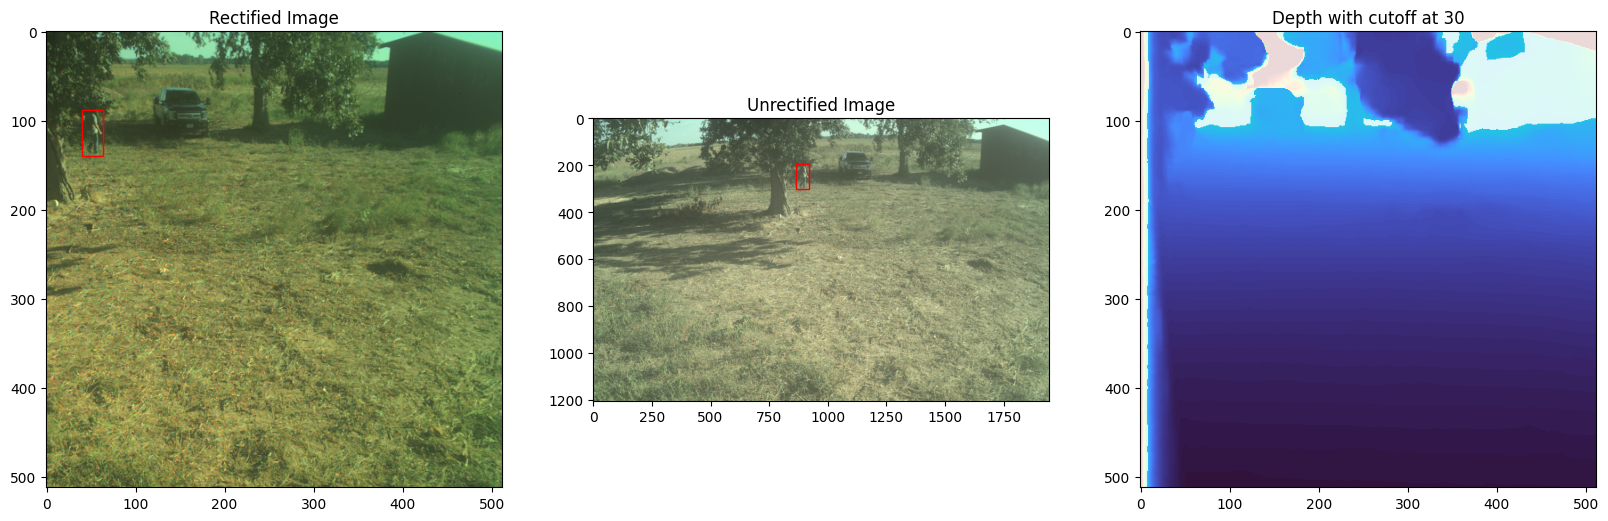

1 Id: 66eb5257d8a625be7814121e , unique_id: 66eb5257d8a625be7814121e_T06_T08


camera_location: T06 collected_on: 2024-08-16T23:12:56.853000
[('result_state', 'false_positive')]
{'large_object_pixels_depth_filtered': 0, 'trees_pixels_depth_filtered': 45391, 'implement_pixels_depth_filtered': 0, 'human_pixels_depth_filtered': 1100, 'vehicle_pixels_depth_filtered': 0, 'dust_debris_pixels_depth_filtered': 0, 'birds_pixels_depth_filtered': 0, 'dense_vegetation_pixels_depth_filtered': 0}
Rectified bbox: 632 163 659 104 27 -59
Unrectified bbox: 869 301 925 191 56 -110


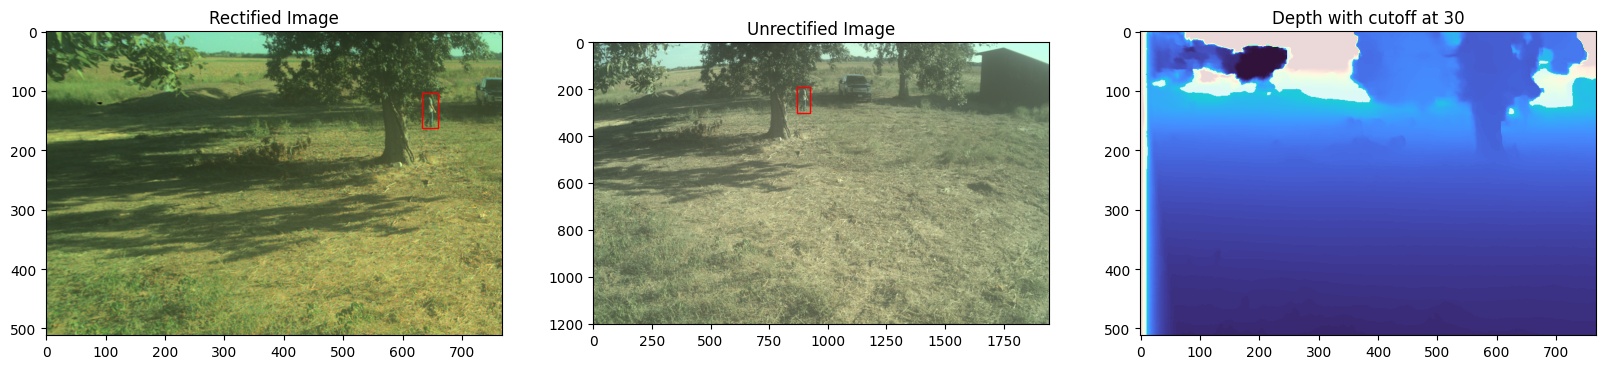

In [165]:
import random

import imageio
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import torch
import matplotlib as mpl

from dl.dataset.datamodes.npz.rgbd import RGBDNPZ
from dl.utils.config import DEFAULT_TONEMAP_PARAMS

# ids = df_select['unique_id']
# ids = df_desired['unique_id']
# ids = df_desired[df_desired['unique_id'].isin(df_select["unique_id"])]["unique_id"]
ids = df_desired[~df_desired['unique_id'].isin(df_select["unique_id"])]["unique_id"]
# ids = df_select[df_select['result_human_state'] == "false_positive"]["unique_id"]
# ids = df_desired[df_desired['result_human_state'] == "false_positive"]["unique_id"]
# ids = df_desired[(df_desired["dense_vegetation_pixels_depth_filtered"].between(75, 5_000) | df_desired["human_pixels_depth_filtered"].between(75, 2_000) | df_desired["large_object_pixels_depth_filtered"].between(75, 1_500)) & df_desired["vehicle_pixels_depth_filtered"].between(-1, 75)]["unique_id"]
# ids = df_desired[df_desired["human_pixels_depth_filtered"] > 2_000]["unique_id"]
# ids = df_desired[df_desired["dense_vegetation_pixels_depth_filtered"] > 1_000]["unique_id"]
# ids = df_desired[df_desired["large_object_pixels_depth_filtered"] > 1_000]["unique_id"]

print('Num ids:', len(ids))
num = 30
if len(ids) > num:
    ids = random.sample(list(ids), num)

dataloader = RGBDNPZ(dataset_dir, run_productivity_metrics=True, normalization_params=DEFAULT_TONEMAP_PARAMS)

num_plots = 3

if not os.path.exists(os.path.join(dataset_dir, "images")):
    num_plots = 2

for i,unique_id in enumerate(ids): 
    sample_row = df[df["unique_id"] == unique_id].iloc[0]
    id_ = sample_row["id"]
    
    print(i, 'Id:', id_, ', unique_id:', sample_row.get('unique_id'))
    
    display(HTML(f"<a href=https://aletheia.brtws.com/images/{id_}>https://aletheia.brtws.com/images/{id_}</a>"))

    model_output = ast.literal_eval(sample_row['features'])
    
    artifacts = dataloader.get_artifacts(sample_row)
    img = artifacts['image']

    unrectified_image_path = os.path.join(dataset_dir, save_path if pd.notna(save_path := sample_row.get("artifact_debayeredrgb_0_save_path")) else sample_row.get("artifact_rgb_0_save_path"))
    if os.path.exists(unrectified_image_path):
        unrectified_image = imageio.v2.imread(unrectified_image_path)

    print("camera_location:", sample_row["camera_location"], "collected_on:", sample_row["collected_on"])
    cols = ["result_state"]
    print([(col, sample_row[col]) for col in cols if col in sample_row])
    if "features" in sample_row:
        print({k: v for k,v in eval(sample_row["features"]).items() if k.endswith("pixels_depth_filtered")})
    
    plt.figure(figsize=(15,30))
    ax = plt.subplot(1,num_plots,1)
    for label_name in LABELS:
        if label_name in DESIRED_LABELS and model_output[f"{label_name}_pixels_depth_filtered"] > 0:
            left, top, right, bottom = model_output[f"{label_name}_min_col_depth_filtered"], model_output[f"{label_name}_min_row_depth_filtered"], model_output[f"{label_name}_max_col_depth_filtered"], model_output[f"{label_name}_max_row_depth_filtered"]
            width = right - left
            height = top - bottom
            ax.add_patch(mpl.patches.Rectangle((left, bottom), width, height, linewidth=1, edgecolor="red", facecolor='none'))
            print("Rectified bbox:", left, bottom, right, top, width, height)
    plt.imshow(img)
    plt.title('Rectified Image')

    if num_plots == 3:
        ax = plt.subplot(1,num_plots,2)
        unrectified_bboxes = unrectify_row(sample_row, dataset_dir)
        for bbox in unrectified_bboxes:
            left, top = bbox["top_left"]
            right, bottom = bbox["bottom_right"]
            width = right - left
            height = top - bottom
            ax.add_patch(mpl.patches.Rectangle((left, bottom), width, height, linewidth=1, edgecolor="red", facecolor='none'))
            print("Unrectified bbox:", left, bottom, right, top, width, height)
        plt.imshow(unrectified_image)
        plt.title('Unrectified Image')

    depth = np.squeeze(artifacts["depth"])
    valid_mask = depth < 0.3
    alpha = np.where(~valid_mask, 0.15, 1.0)
    
    depth_viz = depth
    plt.subplot(1,num_plots, num_plots)
    plt.imshow(depth_viz, cmap='turbo', alpha=alpha)
    plt.title(f'Depth with cutoff at {30}m')
    
    plt.show()